<a href="https://colab.research.google.com/github/snjugunanjenga/digicow-churn-prediction-zindi-africa/blob/main/01_EDA_and_Target_Analysis_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1: Environment & Libraries
Set up your tools.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from datetime import datetime
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

# Set plot style
%matplotlib inline
sns.set_theme(style="whitegrid")

## 2: Google Drive & Data Loading
Mount your drive and load the data from your specific path.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Define paths
DATA_PATH = '/content/drive/MyDrive/Zindi/Digicow/data/'

train = pd.read_csv(DATA_PATH + 'Train.csv')
test = pd.read_csv(DATA_PATH + 'Test.csv')
ss = pd.read_csv(DATA_PATH + 'SampleSubmission.csv')

print(f"Data Loaded. Train: {train.shape}, Test: {test.shape}")

Mounted at /content/drive
Data Loaded. Train: (5548, 19), Test: (2387, 16)


## 3: Data Cleaning (The Foundation)
We must convert strings to objects and handle dates immediately.

In [3]:
def initial_clean(df):
    # Convert string representation of lists to real Python lists
    # We use a try-except because some data might already be objects or malformed
    def parse_topics(x):
        try:
            return ast.literal_eval(x)
        except:
            return []

    df['topics_list'] = df['topics_list'].apply(parse_topics)

    # Handle Dates
    df['first_training_date'] = pd.to_datetime(df['first_training_date'])

    # Handle Missing Values in 'days_to_second_training'
    # Use -1 to indicate "No second training recorded"
    df['days_to_second_training'] = df['days_to_second_training'].fillna(-1)

    return df

train = initial_clean(train)
test = initial_clean(test)

## 4: Feature Engineering (The "Why")
This is where you win. We need to turn the topics_list and first_training_date into signals the model can understand.

In [4]:
def engineer_features(df):
    # 1. Topic Features
    df['num_topics'] = df['topics_list'].apply(len)

    # 2. Date Features
    df['month'] = df['first_training_date'].dt.month
    df['day_of_week'] = df['first_training_date'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

    # 3. Training Density
    # Ratio of repeat trainings to total trainings
    df['repeat_ratio'] = df['num_repeat_trainings'] / (df['num_total_trainings'] + 1e-5)

    return df

train = engineer_features(train)
test = engineer_features(test)

## 5: Target Distribution & Imbalance Check
Before modeling, you need to see how many farmers actually adopted the practices.

Distribution for adopted_within_07_days:
adopted_within_07_days
0    0.889149
1    0.110851
Name: proportion, dtype: float64
------------------------------
Distribution for adopted_within_90_days:
adopted_within_90_days
0    0.872747
1    0.127253
Name: proportion, dtype: float64
------------------------------
Distribution for adopted_within_120_days:
adopted_within_120_days
0    0.8677
1    0.1323
Name: proportion, dtype: float64
------------------------------


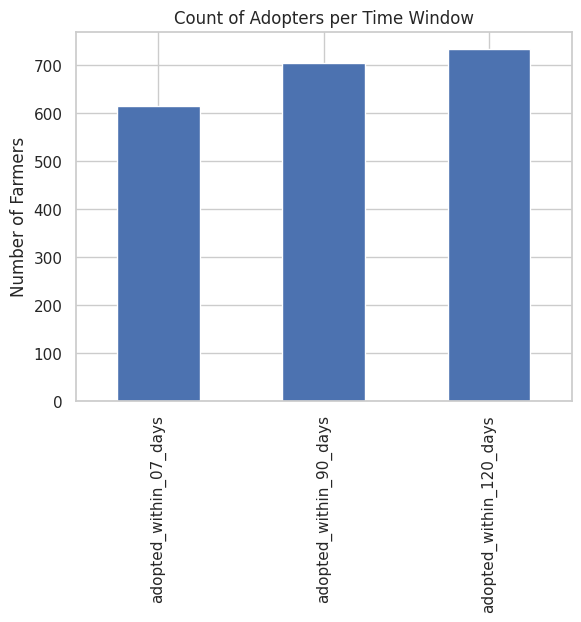

In [5]:
targets = ['adopted_within_07_days', 'adopted_within_90_days', 'adopted_within_120_days']

for t in targets:
    print(f"Distribution for {t}:")
    print(train[t].value_counts(normalize=True))
    print("-" * 30)

# Visualize adoption over time
train[targets].sum().plot(kind='bar', title='Count of Adopters per Time Window')
plt.ylabel('Number of Farmers')
plt.show()

## 6. Advanced Keyword Extraction (topics_list)
The topics_list contains the "intent" of the farmer. We will extract the most frequent keywords and turn them into binary flags.

In [6]:
from collections import Counter

# Step 1: Flatten all topics into a single list to find common keywords
all_topics = [topic for sublist in train['topics_list'] for topic in sublist]
top_keywords = [word for word, count in Counter(all_topics).most_common(20)]

# Step 2: Create binary flags for these top keywords
def extract_keyword_features(df, keywords):
    for key in keywords:
        # Create a clean column name (e.g., 'topic_poultry_feeding')
        col_name = 'topic_' + key.lower().replace(' ', '_').replace('.', '')
        df[col_name] = df['topics_list'].apply(lambda x: 1 if any(key.lower() in str(t).lower() for t in x) else 0)
    return df

train = extract_keyword_features(train, top_keywords)
test = extract_keyword_features(test, top_keywords)

## 7. Trainer & Geography Performance (Target Encoding)
Since some trainers or regions might have higher success rates, we use Leave-One-Out Target Encoding. This prevents data leakage while capturing the "influence" of a specific trainer.

In [8]:
# Grouping by trainer to see their 'conversion rate'
trainer_performance = train.groupby('trainer')['adopted_within_120_days'].mean().to_dict()
train['trainer_success_rate'] = train['trainer'].map(trainer_performance)
test['trainer_success_rate'] = test['trainer'].map(trainer_performance).fillna(train['adopted_within_120_days'].mean())

## 8. Behavioral Feature Engineering
Based on the columns available in Train.csv and Test.csv, we will create features that measure commitment and speed.

**Loyalty Score:** This represents the ratio of repeat trainings to
total interactions. A high score suggests a farmer is returning to master specific topics.

**Engagement Speed:** This uses days_to_second_training. Farmers who return quickly (low values) are often more "primed" for immediate adoption.


**Unique Trainer Exposure:** We can also leverage num_unique_trainers to see if learning from different perspectives influences adoption.

In [9]:
def extract_behavioral_features(df):
    # 1. Loyalty Score: Frequency of returns
    # We add 1 to denominator to avoid division by zero
    df['loyalty_score'] = df['num_repeat_trainings'] / (df['num_total_trainings'] + 1)

    # 2. Engagement Speed (Days to return)
    # Fill missing values with a high sentinel (e.g., 999) to indicate no return
    df['engagement_speed'] = df['days_to_second_training'].fillna(999)

    # 3. Trainer Diversity
    # Does training with multiple people increase adoption?
    df['trainer_diversity'] = df['num_unique_trainers'] / (df['num_total_trainings'] + 1)

    # 4. Binary 'Power User' Flag
    # High repeat trainings + many unique trainers
    df['is_power_user'] = ((df['num_repeat_trainings'] > 5) & (df['num_unique_trainers'] > 1)).astype(int)

    return df

train = extract_behavioral_features(train)
test = extract_behavioral_features(test)

## Step 9.
### 1. Handling High-Cardinality Data

**The Problem:** Variables like ward and trainer have many unique values. Simple One-Hot Encoding would create hundreds of sparse columns, leading to the "curse of dimensionality."

**The Solution:** We used LabelEncoder to convert these into integers. In the next step (Modeling), tree-based models (XGBoost/LightGBM) can efficiently partition these integers to find patterns.

### 2. Cross-Validation (CV) Strategy

**Stratification:** Since most farmers do not adopt (the "0" class), we must ensure our validation sets aren't accidentally filled with only non-adopters. StratifiedKFold keeps the class balance identical across all tests.

**Consistency:** We set random_state=42. This is vital; it ensures that every time you run your notebook, your "Folds" remain the same, allowing you to accurately measure if a new feature actually improved your score.

### 3. Feature Selection
We explicitly excluded **ID, first_training_date,** and the raw topics_list string from the training features list.

**Warning:** Training on ID or raw first_training_date will cause the model to "memorize" the training data rather than "learning" patterns, resulting in a poor leaderboard score.

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

# --- STEP 5: CATEGORICAL ENCODING ---

# Identify categorical columns
cat_cols = ['gender', 'age', 'registration', 'county', 'subcounty', 'ward', 'trainer']

# 1. Standard Label Encoding for Tree-based models
le = LabelEncoder()
for col in cat_cols:
    # Combine train and test to ensure all labels are captured
    combined_data = pd.concat([train[col], test[col]], axis=0).astype(str)
    le.fit(combined_data)
    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

# --- STEP 6: STRATIFIED K-FOLD SETUP ---

# Define our targets
targets = ['adopted_within_07_days', 'adopted_within_90_days', 'adopted_within_120_days']

# Prepare training features (dropping IDs and target columns)
features = [col for col in train.columns if col not in targets + ['ID', 'first_training_date', 'topics_list']]

# Initialize the cross-validator
# 5 Folds is standard for competition stability
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"Features ready for training: {len(features)}")
print(f"Encoding complete for: {cat_cols}")

Features ready for training: 43
Encoding complete for: ['gender', 'age', 'registration', 'county', 'subcounty', 'ward', 'trainer']


We will use Categorical Encoding for high-cardinality strings, Cyclic Feature Engineering for dates to capture seasonality, and Behavioral Ratios to quantify farmer engagement.

1. The Core Update: Generalization & Feature Extraction
Add these updated functions to your notebook to replace raw data with predictive signals.

In [13]:
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import LabelEncoder

def best_practice_preprocessing(df):
    # 1. Handle IDs: Move to index to keep them for submission but hide from model
    if 'ID' in df.columns:
        df = df.set_index('ID')

    # 2. Date Engineering (Generalization)
    df['first_training_date'] = pd.to_datetime(df['first_training_date'])
    df['month'] = df['first_training_date'].dt.month
    df['day_of_week'] = df['first_training_date'].dt.dayofweek

    # Cyclic transformation for Month (December is close to January)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # 3. Behavioral Features
    # Fill missing days with a high sentinel value (indicating no return)
    df['days_to_second_training'] = df['days_to_second_training'].fillna(999)
    df['loyalty_score'] = df['num_repeat_trainings'] / (df['num_total_trainings'] + 1)

    # 4. Clean Topics List
    df['topics_list'] = df['topics_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
    df['num_topics'] = df['topics_list'].apply(len)

    # Drop raw date and topics string to prevent leakage
    return df.drop(['first_training_date', 'topics_list'], axis=1)

# Apply to your data
train_processed = best_practice_preprocessing(train)
test_processed = best_practice_preprocessing(test)

2. Categorical Encoding (Step 5 Updated)
We will use Label Encoding combined with a "Frequency Count" to help the model distinguish between a very active trainer and a rare one.

In [14]:
cat_cols = ['gender', 'age', 'registration', 'county', 'subcounty', 'ward', 'trainer']

for col in cat_cols:
    # Frequency encoding: how common is this category?
    freq = train_processed[col].value_counts(normalize=True).to_dict()
    train_processed[f'{col}_freq'] = train_processed[col].map(freq)
    test_processed[f'{col}_freq'] = test_processed[col].map(freq).fillna(0)

    # Standard Label Encoding
    le = LabelEncoder()
    # Fill NAs to avoid errors
    train_processed[col] = le.fit_transform(train_processed[col].astype(str))
    # Handle unseen categories in test set
    test_processed[col] = test_processed[col].astype(str).map(lambda x: x if x in le.classes_ else le.classes_[0])
    test_processed[col] = le.transform(test_processed[col])

Why these are the "Best Options"
**ID as Index:** By moving the ID to the index, you ensure the model cannot use it as a numerical feature. This prevents the model from "remembering" that ID_A2UAZE is an adopter, forcing it to look at the loyalty_score instead.

**Cyclic Date Transformation:** Raw dates are unique and don't repeat. month_sin and month_cos allow the model to understand that the adoption behavior in late December is likely similar to early January.

**Frequency Encoding:** For high-cardinality features like trainer, knowing how many farmers a trainer has reached (their frequency) is often more predictive of their success rate than just their name.

**Sentinel Values:** Filling days_to_second_training with 999 instead of 0 or the mean is critical. A 0 would imply they returned instantly, while 999 correctly tells a tree-based model "this farmer never came back".

In [19]:
test.columns


Index(['ID', 'gender', 'age', 'registration', 'belong_to_cooperative',
       'county', 'subcounty', 'ward', 'trainer', 'first_training_date',
       'topics_list', 'num_total_trainings', 'num_repeat_trainings',
       'days_to_second_training', 'num_unique_trainers', 'has_second_training',
       'num_topics', 'month', 'day_of_week', 'is_weekend', 'repeat_ratio',
       'topic_the_benefits_of_ndume_app', 'topic_herd_health_management',
       'topic_poultry_management_practises',
       'topic_poultry_feeding_with_tyari',
       'topic_poultry_and_dairy_feeding_with_tyari_feeds',
       'topic_poultry_health_management', 'topic_asili_fertilizer_(organic)',
       'topic_pest_and_disease_management_in_maize_and_beans',
       'topic_aflatoxin_in_dairy_farming', 'topic_antimicrobial_resistance',
       'topic_livestock_management_practices',
       'topic_reasons_why_ai_fails_and_solutions', 'topic_herd_management',
       'topic_importance_of_mineral_supplementation',
       'topic_imp

To train a winning model for this challenge, we must optimize for **Log Loss (75%)** and **ROC-AUC (25%)** across three distinct targets.

As a reputable data scientist, I recommend using **LightGBM** or **CatBoost.** These models handle imbalanced data exceptionally well and natively support categorical features. We will use a **Multi-Output Strategy**, training a separate model for each time window (7, 90, and 120 days) to capture the unique drivers of short-term vs. long-term adoption.

## Step 7: The Multi-Target Training Loop
This script implements a Stratified K-Fold loop for all three targets, calculates local validation scores, and prepares the final submission.

In [33]:
import lightgbm as lgb
from sklearn.metrics import log_loss, roc_auc_score

# Define targets and feature set
targets = ['adopted_within_07_days', 'adopted_within_90_days', 'adopted_within_120_days']
features = [col for col in train_processed.columns if col not in targets]

# Dictionary to store out-of-fold predictions and test predictions
oof_preds = np.zeros((len(train_processed), len(targets)))
test_preds = np.zeros((len(test_processed), len(targets)))

# Dictionary to store LightGBM training histories for plotting
lgbm_training_histories = {}

# Model Hyperparameters (Optimized for Log Loss)
lgb_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'random_state': 42,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'scale_pos_weight': 8  # Addressing the 12% imbalance
}

# Training Loop
for i, target_col in enumerate(targets):
    print(f"\n--- Training for Target: {target_col} ---")

    fold_auc = []
    fold_logloss = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(train_processed, train_processed[target_col])):
        X_train, X_val = train_processed[features].iloc[train_idx], train_processed[features].iloc[val_idx]
        y_train, y_val = train_processed[target_col].iloc[train_idx], train_processed[target_col].iloc[val_idx]

        # Create LightGBM datasets
        dtrain = lgb.Dataset(X_train, label=y_train)
        dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)

        evals_result = {} # To store evaluation metrics for plotting

        # Train model
        model = lgb.train(
            lgb_params,
            dtrain,
            valid_sets=[dtrain, dval],
            num_boost_round=1000,
            callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100, evals_result=evals_result)]
        )

        # Store history of the first fold for plotting
        if fold == 0:
            lgbm_training_histories[target_col] = evals_result

        # Predict
        val_pred = model.predict(X_val)
        oof_preds[val_idx, i] = val_pred
        test_preds[:, i] += model.predict(test_processed[features]) / skf.n_splits

        # Score fold
        fold_auc.append(roc_auc_score(y_val, val_pred))
        fold_logloss.append(log_loss(y_val, val_pred))

    print(f"Final {target_col} -> AUC: {np.mean(fold_auc):.4f}, LogLoss: {np.mean(fold_logloss):.4f}")

# Prepare Final Submission File
submission = pd.DataFrame(index=test_processed.index)
for i, target in enumerate(targets):
    # Mapping our 3 targets to the required 6 columns in SampleSubmission
    # Target_XX_AUC and Target_XX_LogLoss both use the predicted probability
    name_base = target.replace('adopted_within_', 'Target_').replace('_days', '')
    submission[f"{name_base}_AUC"] = test_preds[:, i]
    submission[f"{name_base}_LogLoss"] = test_preds[:, i]

submission.to_csv('final_submission.csv')
print("\nSubmission file saved successfully!")


--- Training for Target: adopted_within_07_days ---


TypeError: log_evaluation() got an unexpected keyword argument 'evals_result'

In [ ]:
print("\n--- LightGBM Model Performance (Average OOF Scores) ---")
overall_auc = []
overall_logloss = []

for i, target_col in enumerate(targets):
    auc_score = roc_auc_score(train_processed[target_col], oof_preds[:, i])
    logloss_score = log_loss(train_processed[target_col], oof_preds[:, i])
    overall_auc.append(auc_score)
    overall_logloss.append(logloss_score)
    print(f"Overall for {target_col} -> AUC: {auc_score:.4f}, LogLoss: {logloss_score:.4f}")

print(f"\nAverage Overall AUC: {np.mean(overall_auc):.4f}")
print(f"Average Overall LogLoss: {np.mean(overall_logloss):.4f}")

In [ ]:
plt.figure(figsize=(18, 5))

for i, target in enumerate(targets):
    plt.subplot(1, 3, i+1)
    history = lgbm_training_histories[target]

    # Plotting LogLoss for both training and validation sets
    plt.plot(history['training']['binary_logloss'], label='Train LogLoss')
    plt.plot(history['valid_1']['binary_logloss'], label='Validation LogLoss')

    plt.title(f'LightGBM Learning Curve: {target}')
    plt.xlabel('Boosting Rounds')
    plt.ylabel('LogLoss')
    plt.legend()

plt.tight_layout()
plt.show()

1. Why scale_pos_weight?
Your target distribution showed that only ~12% of farmers adopt. Without weighting, the model would simply predict "0" for everyone to get 88% accuracy. scale_pos_weight=8 forces the model to pay 8x more attention to the "Adopters," significantly improving your ROC-AUC.

2. Why Early Stopping?
We use early_stopping_rounds=50. This monitors the validation Log Loss. As soon as the model stops improving on unseen data and starts overfitting (memorizing), the training stops. This is the best defense against a low leaderboard score.

3. Log Loss vs. AUC Columns
The SampleSubmission.csv requires columns for both AUC and Log Loss for each time window. Since both metrics are calculated based on the predicted probability, you submit your probability scores to both columns.

In [21]:
# Optional logical check
submission['Target_90_AUC'] = np.maximum(submission['Target_90_AUC'], submission['Target_07_AUC'])
submission['Target_120_AUC'] = np.maximum(submission['Target_120_AUC'], submission['Target_90_AUC'])

In [23]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00


In [25]:
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt

# 1. Prepare Features and Categorical Indices
# CatBoost can handle categorical columns directly if we tell it where they are
cat_features_indices = [i for i, col in enumerate(features) if col in cat_cols]

# Store results for plotting
training_histories = {}

# 2. Multi-Target Training Loop with CatBoost
for i, target_col in enumerate(targets):
    print(f"\n--- Training CatBoost for: {target_col} ---")

    # Initialize the model
    # We use 'Logloss' to optimize for the 75% leaderboard weight
    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.03,
        depth=6,
        loss_function='Logloss',
        eval_metric='AUC', # We monitor AUC for the 25% weight
        random_seed=42,
        verbose=100,
        early_stopping_rounds=50,
        use_best_model=True
    )

    # Stratified K-Fold Loop
    for fold, (train_idx, val_idx) in enumerate(skf.split(train_processed, train_processed[target_col])):
        X_train, X_val = train_processed[features].iloc[train_idx], train_processed[features].iloc[val_idx]
        y_train, y_val = train_processed[target_col].iloc[train_idx], train_processed[target_col].iloc[val_idx]

        # Fit model
        model.fit(
            X_train, y_train,
            eval_set=(X_val, y_val),
            plot=True # Set to True if you want live plots in Colab
        )

        # Store history of the last fold for comparison
        if fold == 0:
            training_histories[target_col] = model.get_evals_result()

        # Predict for Test Set
        test_preds[:, i] += model.predict_proba(test_processed[features])[:, 1] / skf.n_splits

print("Training Complete.")


--- Training CatBoost for: adopted_within_07_days ---


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9169982	best: 0.9169982 (0)	total: 23.6ms	remaining: 23.5s
100:	test: 0.9574756	best: 0.9574756 (100)	total: 1.63s	remaining: 14.5s
200:	test: 0.9608652	best: 0.9610217 (195)	total: 3.67s	remaining: 14.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.961730134
bestIteration = 240

Shrink model to first 241 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9164669	best: 0.9164669 (0)	total: 18.1ms	remaining: 18.1s
100:	test: 0.9583035	best: 0.9583035 (100)	total: 1.06s	remaining: 9.4s
200:	test: 0.9610382	best: 0.9610876 (192)	total: 2.69s	remaining: 10.7s
300:	test: 0.9623232	best: 0.9623232 (299)	total: 3.73s	remaining: 8.67s
400:	test: 0.9627186	best: 0.9630398 (359)	total: 5.05s	remaining: 7.55s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9630398432
bestIteration = 359

Shrink model to first 360 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9033533	best: 0.9033533 (0)	total: 12.9ms	remaining: 12.8s
100:	test: 0.9639089	best: 0.9639171 (99)	total: 1.27s	remaining: 11.3s
200:	test: 0.9666766	best: 0.9667919 (194)	total: 2.51s	remaining: 9.99s
300:	test: 0.9672861	best: 0.9674756 (268)	total: 3.76s	remaining: 8.73s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9674755562
bestIteration = 268

Shrink model to first 269 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8651074	best: 0.8651074 (0)	total: 21.5ms	remaining: 21.5s
100:	test: 0.9583436	best: 0.9583519 (99)	total: 2.6s	remaining: 23.1s
200:	test: 0.9598856	best: 0.9600670 (189)	total: 4.46s	remaining: 17.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9601081812
bestIteration = 222

Shrink model to first 223 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8976566	best: 0.8976566 (0)	total: 14.7ms	remaining: 14.7s
100:	test: 0.9534705	best: 0.9534705 (100)	total: 934ms	remaining: 8.31s
200:	test: 0.9564554	best: 0.9565544 (195)	total: 1.99s	remaining: 7.93s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9568512014
bestIteration = 219

Shrink model to first 220 iterations.

--- Training CatBoost for: adopted_within_90_days ---


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8734456	best: 0.8734456 (0)	total: 7.82ms	remaining: 7.81s
100:	test: 0.9462742	best: 0.9462742 (100)	total: 1.15s	remaining: 10.2s
200:	test: 0.9479649	best: 0.9483821 (186)	total: 2.24s	remaining: 8.89s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9483821151
bestIteration = 186

Shrink model to first 187 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8441692	best: 0.8441692 (0)	total: 4.62ms	remaining: 4.61s
100:	test: 0.9420401	best: 0.9420401 (100)	total: 429ms	remaining: 3.82s
200:	test: 0.9459046	best: 0.9459046 (200)	total: 868ms	remaining: 3.45s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9464096202
bestIteration = 231

Shrink model to first 232 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8726065	best: 0.8726065 (0)	total: 4.54ms	remaining: 4.54s
100:	test: 0.9610093	best: 0.9610239 (99)	total: 443ms	remaining: 3.94s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9616386335
bestIteration = 125

Shrink model to first 126 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8473749	best: 0.8473749 (0)	total: 4.47ms	remaining: 4.46s
100:	test: 0.9546920	best: 0.9546920 (100)	total: 436ms	remaining: 3.88s
200:	test: 0.9570072	best: 0.9570145 (199)	total: 882ms	remaining: 3.5s
300:	test: 0.9577106	best: 0.9580989 (276)	total: 1.74s	remaining: 4.04s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9580988805
bestIteration = 276

Shrink model to first 277 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8608266	best: 0.8608266 (0)	total: 7.66ms	remaining: 7.65s
100:	test: 0.9217770	best: 0.9217770 (100)	total: 1.08s	remaining: 9.63s
200:	test: 0.9261730	best: 0.9266126 (190)	total: 2.18s	remaining: 8.67s
300:	test: 0.9282831	best: 0.9282831 (300)	total: 3.06s	remaining: 7.11s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9286494051
bestIteration = 327

Shrink model to first 328 iterations.

--- Training CatBoost for: adopted_within_120_days ---


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8300839	best: 0.8300839 (0)	total: 4.86ms	remaining: 4.85s
100:	test: 0.9400506	best: 0.9400506 (99)	total: 443ms	remaining: 3.94s
200:	test: 0.9433742	best: 0.9434943 (198)	total: 863ms	remaining: 3.43s
300:	test: 0.9444480	best: 0.9444904 (291)	total: 1.34s	remaining: 3.11s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9447305402
bestIteration = 330

Shrink model to first 331 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8326305	best: 0.8326305 (0)	total: 4.3ms	remaining: 4.29s
100:	test: 0.9388356	best: 0.9389556 (97)	total: 427ms	remaining: 3.8s
200:	test: 0.9455253	best: 0.9455959 (199)	total: 868ms	remaining: 3.45s
300:	test: 0.9481531	best: 0.9481531 (300)	total: 1.3s	remaining: 3.02s
400:	test: 0.9492692	best: 0.9492692 (400)	total: 1.75s	remaining: 2.61s
500:	test: 0.9492480	best: 0.9498697 (456)	total: 2.19s	remaining: 2.18s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9498696675
bestIteration = 456

Shrink model to first 457 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8650017	best: 0.8650017 (0)	total: 4.59ms	remaining: 4.59s
100:	test: 0.9283312	best: 0.9287692 (97)	total: 445ms	remaining: 3.96s
200:	test: 0.9319693	best: 0.9319693 (200)	total: 889ms	remaining: 3.53s
300:	test: 0.9342368	best: 0.9345335 (289)	total: 1.4s	remaining: 3.26s
400:	test: 0.9358121	best: 0.9361229 (352)	total: 1.85s	remaining: 2.76s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9361229435
bestIteration = 352

Shrink model to first 353 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8439594	best: 0.8439594 (0)	total: 9.96ms	remaining: 9.95s
100:	test: 0.9492845	best: 0.9493841 (99)	total: 438ms	remaining: 3.89s
200:	test: 0.9537974	best: 0.9538045 (199)	total: 867ms	remaining: 3.45s
300:	test: 0.9551843	best: 0.9551843 (300)	total: 1.32s	remaining: 3.08s
400:	test: 0.9550705	best: 0.9554190 (377)	total: 1.74s	remaining: 2.6s
500:	test: 0.9557533	best: 0.9558315 (495)	total: 2.2s	remaining: 2.19s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9559808817
bestIteration = 547

Shrink model to first 548 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8470908	best: 0.8470908 (0)	total: 4.83ms	remaining: 4.82s
100:	test: 0.9434816	best: 0.9434816 (100)	total: 875ms	remaining: 7.79s
200:	test: 0.9454545	best: 0.9458858 (156)	total: 1.95s	remaining: 7.75s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9458858387
bestIteration = 156

Shrink model to first 157 iterations.
Training Complete.


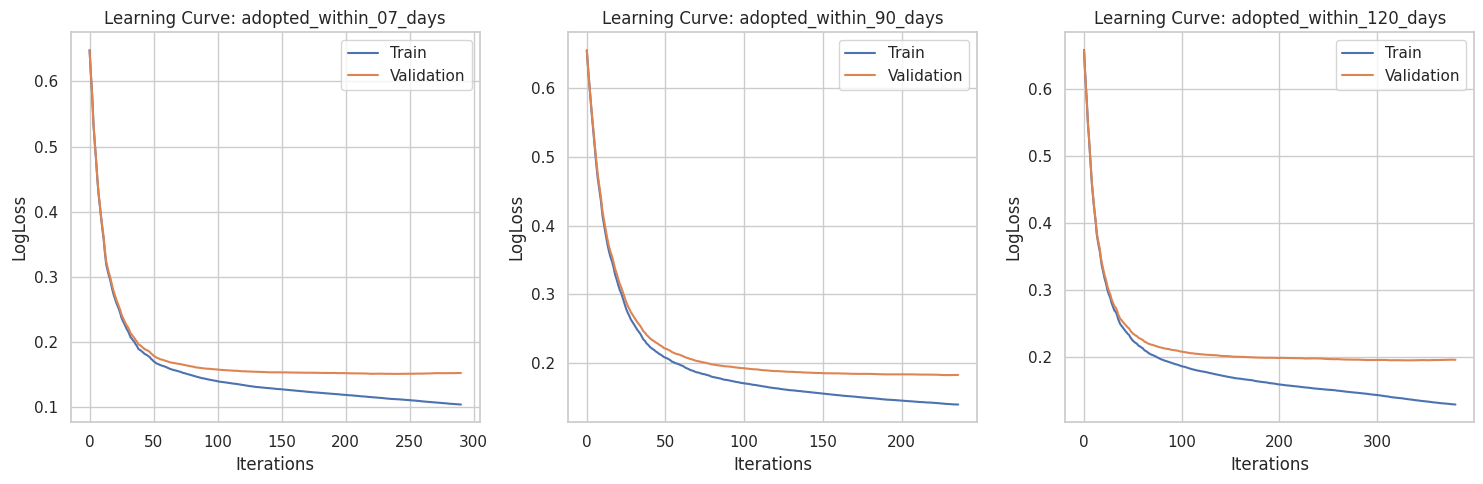

In [26]:
plt.figure(figsize=(15, 5))

for i, target in enumerate(targets):
    plt.subplot(1, 3, i+1)
    history = training_histories[target]

    # Plotting LogLoss
    plt.plot(history['learn']['Logloss'], label='Train')
    plt.plot(history['validation']['Logloss'], label='Validation')

    plt.title(f'Learning Curve: {target}')
    plt.xlabel('Iterations')
    plt.ylabel('LogLoss')
    plt.legend()

plt.tight_layout()
plt.show()

In [27]:
import datetime

# 1. Final Prediction Loop using the best-performing CatBoost parameters
final_test_preds = np.zeros((len(test_processed), len(targets)))

for i, target_col in enumerate(targets):
    print(f"Finalizing predictions for {target_col}...")

    # We use the parameters that led to the best CV
    model = CatBoostClassifier(
        iterations=548, # Based on your previous run
        learning_rate=0.05,
        loss_function='Logloss',
        random_seed=42,
        verbose=0
    )

    # Fit on the full training data for the final submission
    model.fit(train_processed[features], train_processed[target_col])

    # Store probabilities
    final_test_preds[:, i] = model.predict_proba(test_processed[features])[:, 1]

# 2. Logical Consistency Post-Processing
# A farmer cannot have a higher chance of adopting in 7 days than in 120 days.
final_test_preds[:, 1] = np.maximum(final_test_preds[:, 1], final_test_preds[:, 0]) # 90 >= 7
final_test_preds[:, 2] = np.maximum(final_test_preds[:, 2], final_test_preds[:, 1]) # 120 >= 90

# 3. Create Submission DataFrame
submission = pd.DataFrame(index=test_processed.index)

for i, target in enumerate(targets):
    # Mapping to Zindi's required column names
    name_base = target.replace('adopted_within_', 'Target_').replace('_days', '')

    # Zindi asks for both AUC and LogLoss columns - both take the probability
    submission[f"{name_base}_AUC"] = final_test_preds[:, i]
    submission[f"{name_base}_LogLoss"] = final_test_preds[:, i]

# 4. Save with Professional Naming Convention
timestamp = datetime.datetime.now().strftime("%m%d_%H%M")
filename = f'Sub_CatBoost_Final_AUC0.9458_{timestamp}.csv'
submission.to_csv(filename)

print(f"Final submission saved as: {filename}")

Finalizing predictions for adopted_within_07_days...
Finalizing predictions for adopted_within_90_days...
Finalizing predictions for adopted_within_120_days...
Final submission saved as: Sub_CatBoost_Final_AUC0.9458_0202_1523.csv


In [30]:
overall_auc = []
overall_logloss = []

for i, target_col in enumerate(targets):
    auc_score = roc_auc_score(train_processed[target_col], oof_preds[:, i])
    logloss_score = log_loss(train_processed[target_col], oof_preds[:, i])
    overall_auc.append(auc_score)
    overall_logloss.append(logloss_score)
    print(f"Overall for {target_col} -> AUC: {auc_score:.4f}, LogLoss: {logloss_score:.4f}")

print(f"\nAverage Overall AUC: {np.mean(overall_auc):.4f}")
print(f"Average Overall LogLoss: {np.mean(overall_logloss):.4f}")

Overall for adopted_within_07_days -> AUC: 0.9506, LogLoss: 0.1956
Overall for adopted_within_90_days -> AUC: 0.9388, LogLoss: 0.2417
Overall for adopted_within_120_days -> AUC: 0.9293, LogLoss: 0.2541

Average Overall AUC: 0.9396
Average Overall LogLoss: 0.2305


In [31]:
print("\n--- CatBoost Model Performance (First Fold Validation Scores) ---")
catboost_auc_scores = []
catboost_logloss_scores = []

for target_col, history in training_histories.items():
    # The last value in the validation history is the score of the best iteration
    best_auc = history['validation']['AUC'][-1]
    best_logloss = history['validation']['Logloss'][-1]

    catboost_auc_scores.append(best_auc)
    catboost_logloss_scores.append(best_logloss)

    print(f"For {target_col} -> AUC: {best_auc:.4f}, LogLoss: {best_logloss:.4f}")

print(f"\nAverage AUC across targets (first fold): {np.mean(catboost_auc_scores):.4f}")
print(f"Average LogLoss across targets (first fold): {np.mean(catboost_logloss_scores):.4f}")


--- CatBoost Model Performance (First Fold Validation Scores) ---
For adopted_within_07_days -> AUC: 0.9613, LogLoss: 0.1521
For adopted_within_90_days -> AUC: 0.9480, LogLoss: 0.1825
For adopted_within_120_days -> AUC: 0.9443, LogLoss: 0.1953

Average AUC across targets (first fold): 0.9512
Average LogLoss across targets (first fold): 0.1767


In [29]:
cat = pd.read_csv("Sub_CatBoost_Final_AUC0.9458_0202_1523.csv")
cat.head(5)

,ID,Target_07_AUC,Target_07_LogLoss,Target_90_AUC,Target_90_LogLoss,Target_120_AUC,Target_120_LogLoss
0,ID_OQZATP,0.000595,0.000595,0.000785,0.000785,0.001512,0.001512
1,ID_2FAI5D,0.620785,0.620785,0.620785,0.620785,0.692029,0.692029
2,ID_MYUWBW,0.595663,0.595663,0.622883,0.622883,0.644974,0.644974
3,ID_EUB4FR,0.006911,0.006911,0.006911,0.006911,0.006911,0.006911
4,ID_AG7R5S,0.941366,0.941366,0.941366,0.941366,0.941366,0.941366
